# Анализ маркетинговых показателей приложения Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.\
Задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.
\
Фокусные вопросы для изучения:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.
\

<b>План выполнения проекта:</b>\
Шаг 1. Загрузка данных и подготовка их к анализу\
Шаг 2. Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии\
Шаг 3. Исследовательский анализ данных\
Шаг 4. Маркетинг\
Шаг 5. Оценка окупаемости рекламы\
Шаг 6. Общий вывод

## Загрузка данных и подготовка их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.\
Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [3]:
try:
    df_visits = pd.read_csv('/da/visits_info_short.csv')
except:
    df_visits = pd.read_csv('C\\data\\visits_info_short.csv')
df_visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
df_visits.isna().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [6]:
df_visits.duplicated().sum()

0

В датафрейме с визитами нет пропусков, но некорректно отображается тип данных колонок "Session Start" и "Session End". Формат названий колонок тоже не соответствует стилистическим требованиям.\
Исправим это:

In [7]:
df_visits = df_visits.rename(columns={'User Id': 'user_id', 
                                      'Region': 'region', 
                                      'Device':'device', 
                                      'Channel':'channel', 
                                      'Session Start':'session_start',
                                      'Session End':'session_end'})
df_visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 
    
* Проблема названий столбцов ведь только в том, что имеются пробелы и заглавные буквы, соответственно можно было бы обойтись и без `rename`
* Могу предложить такой вариант `visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]`
    


In [8]:
df_visits['session_start'] = pd.to_datetime(df_visits['session_start'])
df_visits['session_end'] = pd.to_datetime(df_visits['session_end'])

In [9]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Данные в дф скорректированы. 

In [10]:
try:
    df_orders = pd.read_csv('/da/orders_info_short.csv')
except:
    df_orders = pd.read_csv('C\\data\\orders_info_short.csv')
    
df_orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [11]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [12]:
df_orders.isna().sum()

User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [13]:
df_orders.duplicated().sum()

0

Аналогично с предыдущим датасетом нужно привести названия колонок к корретной записи и изменить тип данных в столбце "Event Dt":

In [14]:
df_orders = df_orders.rename(columns={'User Id': 'user_id', 
                                      'Event Dt': 'event_dt', 
                                      'Revenue':'revenue'})
df_orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [15]:
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt'])

In [16]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Данные скорректированы.

In [17]:
try:
    df_costs = pd.read_csv('/da/costs_info_short.csv')
except:
    df_costs = pd.read_csv('C\\data\\costs_info_short.csv')

df_costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [18]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [19]:
df_costs.isna().sum()

dt         0
Channel    0
costs      0
dtype: int64

In [20]:
df_costs.duplicated().sum()

0

In [21]:
df_costs = df_costs.rename(columns={'Channel': 'channel'}) 
df_costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [22]:
df_costs['dt'] = pd.to_datetime(df_costs['dt']).dt.date 

In [23]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [24]:
def my_info_function(df):
    df_info = df.info()
    df_describe = df.describe()
    df_value = df.value_counts()
    df_isna = df.isna().sum()
    df_duplicated = df.duplicated().sum()
    return df_info, df_describe, df_value, df_isna, df_duplicated

In [25]:
my_info_function(df_costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


(None,
              costs
 count  1800.000000
 mean     58.609611
 std     107.740223
 min       0.800000
 25%       6.495000
 50%      12.285000
 75%      33.600000
 max     630.000000,
 dt          channel             costs  
 2019-05-01  AdNonSense          40.950     1
 2019-09-01  WahooNetBanner      36.000     1
 2019-08-29  WahooNetBanner      35.400     1
             TipTop              318.000    1
             RocketSuperAds      5.850      1
                                           ..
 2019-06-29  TipTop              322.400    1
             RocketSuperAds      6.825      1
             OppleCreativeMedia  18.000     1
             MediaTornado        5.520      1
 2019-10-27  lambdaMediaAds      12.000     1
 Length: 1800, dtype: int64,
 dt         0
 channel    0
 costs      0
 dtype: int64,
 0)

<b> Вывод:</b> загружены 3 датасета с данными по визитам, заказам и расходам. В данных не было обнаружено пропусков и дубликатов. Для удобства названия колонок приведены к нижнему регистру и из них убраны пробелы. Тип данных в столбцах с датой приведен к корректному формату datetime. 
    

## Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Функция для создания пользовательских профилей

In [26]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчёта Retention Rate 

In [27]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта конверсии

In [25]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта LTV и ROI

In [26]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания фрейма

In [27]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания

In [28]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция графика конверсии

In [29]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 10))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI

In [30]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

### Профили пользователей

Формируетм таблицу с профилями пользователей, используя формулу:

In [31]:
profiles = get_profiles(df_visits, df_orders, df_costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [32]:
min_date = profiles['first_ts'].min()
print(f'Минимальная дата привлечения пользователей: {min_date}')

Минимальная дата привлечения пользователей: 2019-05-01 00:00:41


In [33]:
max_date = profiles['first_ts'].max()
print(f'Максимальная дата привлечения пользователей: {max_date}')

Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


<b>Вывод: </b> Сформирована таблица с разбивкой данных по пользователям, где указана дата привлечения, канал привлечения, устройство, страна, статус пользователя как ппокупателя и стоимость привлечения. Мы рассматриваем данные за промежуток времени с 1 мая 2019 года по 27 октября 2019 года в который привлекались пользователи.   

### Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей

In [34]:
region_agg = profiles.groupby('region').agg(
    {'payer':['count', 'mean']})
region_agg = region_agg.rename(columns={'count':'count_users', 'mean':'part_payer,%'})
region_agg['payer','part_payer,%'] = round((region_agg['payer','part_payer,%']*100),2)

display(region_agg.sort_values([('payer', 'part_payer,%')], ascending=False))

payer             
              count_users part_payer,%
region                                
United States      100002         6.90
Germany             14981         4.11
UK                  17575         3.98
France              17450         3.80

<b>Вывод: </b> Большее колличество пользователей и самая большая доля платящих пользователей находятся в Великобритании. 

### Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [35]:
device_agg = profiles.groupby('device').agg(
    {'payer':['count','mean']})
device_agg = device_agg.rename(columns={'count':'count_users', 'mean':'part_payer'})
device_agg['payer','part_payer'] = round((device_agg['payer','part_payer']*100),2)
display(device_agg.sort_values([('payer', 'part_payer')], ascending=False))

payer           
        count_users part_payer
device                        
Mac           30042       6.36
iPhone        54479       6.21
Android       35032       5.85
PC            30455       5.05

<b>Вывод: </b> Самое большое колличество пользователей на платформе iPhone. Наименее популярная платформа у пользователей - Mac, при этом доля платящих на ней выше всех - 6.36%. Аутсайдер по продажам и пользователям - PC.

###  Количество пользователей и доля платящих для каждого канала привлечения.

In [36]:
channel_agg = profiles.groupby('channel').agg(
    {'payer':['count','mean']})
channel_agg = channel_agg.rename(columns={'count':'count_users', 'mean':'part_payer'})
channel_agg['payer','part_payer'] = round((channel_agg['payer','part_payer']*100),2)
display(channel_agg.sort_values([('payer', 'part_payer')], ascending=False))
display(channel_agg.sort_values([('payer', 'count_users')], ascending=False))

payer           
                   count_users part_payer
channel                                  
FaceBoom                 29144      12.20
AdNonSense                3880      11.34
lambdaMediaAds            2149      10.47
TipTop                   19561       9.60
RocketSuperAds            4448       7.91
WahooNetBanner            8553       5.30
YRabbit                   4312       3.83
MediaTornado              4364       3.57
LeapBob                   8553       3.06
OppleCreativeMedia        8605       2.71
organic                  56439       2.06

payer           
                   count_users part_payer
channel                                  
organic                  56439       2.06
FaceBoom                 29144      12.20
TipTop                   19561       9.60
OppleCreativeMedia        8605       2.71
LeapBob                   8553       3.06
WahooNetBanner            8553       5.30
RocketSuperAds            4448       7.91
MediaTornado              4364       3.57
YRabbit                   4312       3.83
AdNonSense                3880      11.34
lambdaMediaAds            2149      10.47

<b>Вывод: </b> больше всего пользователей пришли не через рекламную платформу (канал "organic"), при этом у этого канала самая маленькая конверсия покупателей. Больше всего пользователей и покупателей привлекли "FaceBoom" 29144 и 12,2% соответственно.

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [37]:
total_cost = round((df_costs['costs'].sum()),2)
print(f'Общая сумма расходов: {total_cost}')

Общая сумма расходов: 105497.3


<b>Вывод:</b> сумма расходов на рекламу составила 105 497,3. К сожалению, в данных не указаны единицы измерения (млн. тысячи, рубли или $), поэтому необходимо уточнить у коллег эту информацию. 

In [38]:
channel_cost = (
    profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')
    .sort_values(by='acquisition_cost',ascending=False)
)    
channel_cost

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


<b>Вывод:</b> Дороже всего обошлась реклама на площадке TipTop (54751.30). Меньше всего трат было у источника YRabbit(944.22).  

In [39]:
profiles['week']= profiles['first_ts'].dt.isocalendar().week
#profiles

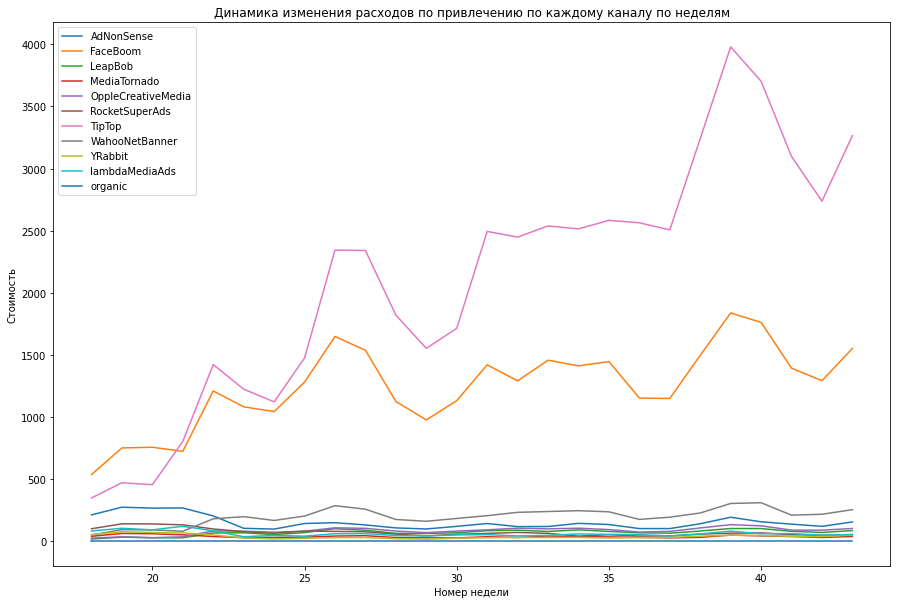

In [40]:
channel_week = (
    profiles.pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum')
)
plt.figure(figsize=(15, 10))
plt.plot(channel_week)
plt.title('Динамика изменения расходов по привлечению по каждому каналу по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Стоимость')
plt.legend(channel_week.columns)
plt.show()

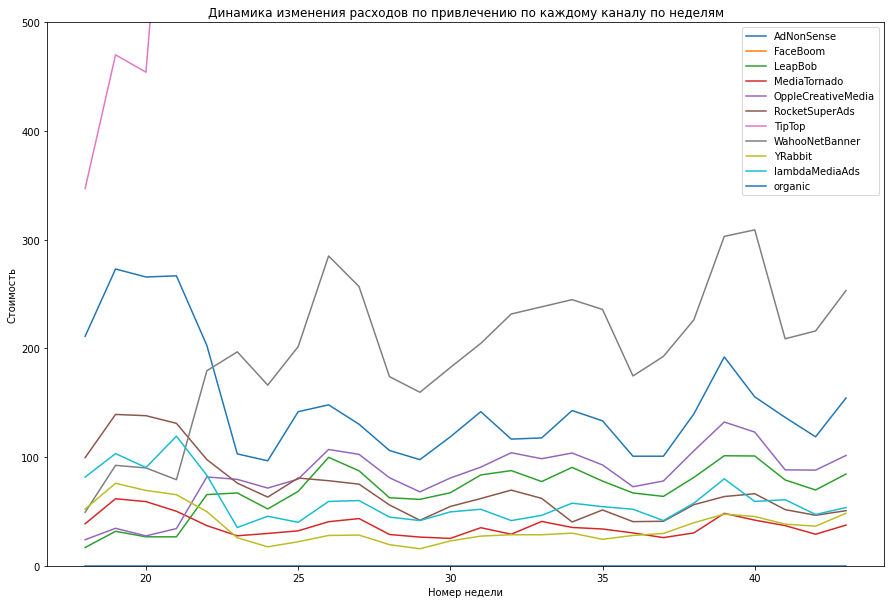

In [41]:
channel_week = (
    profiles.pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='sum')
)
plt.figure(figsize=(15, 10))
plt.plot(channel_week)
plt.title('Динамика изменения расходов по привлечению по каждому каналу по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Стоимость')
plt.legend(channel_week.columns)
plt.ylim([0,500])
plt.show()

<b>Вывод:</b> Затраты на продвижение на площадках TipTop и FaceBoom значительно выше всех остальных каналов. Расходы показывают скачкообразный рост и снижение. На 39 неделе случилось резкое увеличение затрат, а после такое же резкое их сокращение. Сейчас расходы на этих площадках тоже начали расти. 

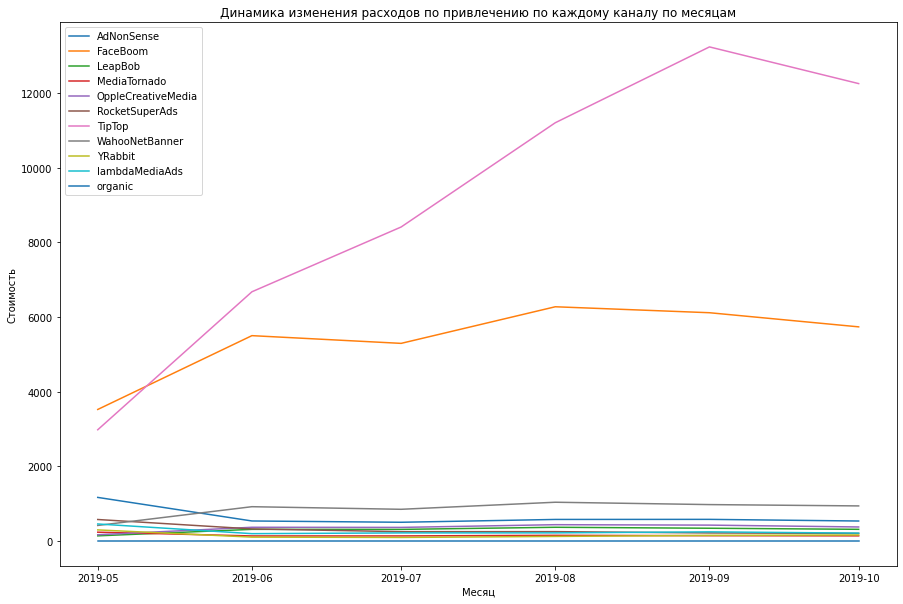

In [42]:
channel_month = (
    profiles.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='sum')
)
plt.figure(figsize=(15, 10))
plt.plot(channel_month)
plt.title('Динамика изменения расходов по привлечению по каждому каналу по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')
plt.legend(channel_month.columns)
plt.show()

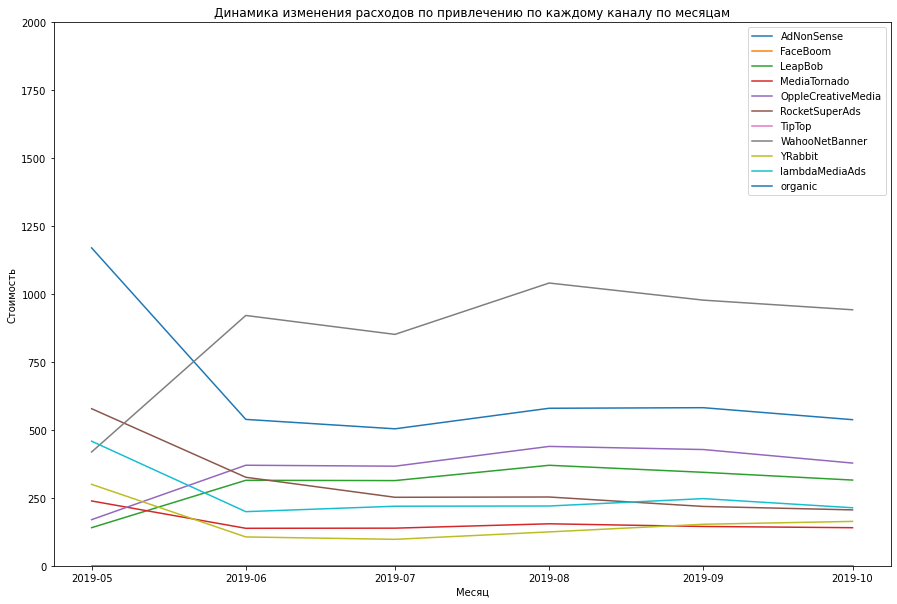

In [43]:
channel_month = (
    profiles.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='sum')
)
plt.figure(figsize=(15, 10))
plt.plot(channel_month)
plt.title('Динамика изменения расходов по привлечению по каждому каналу по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')
plt.legend(channel_month.columns)
plt.ylim([0,2000])
plt.show()

<b>Вывод:</b> Затраты на продвижение на площадках TipTop и FaceBoom значительно выше всех остальных каналов. Расходы на TipTop резко возрастают к сентябрю, а к октябрю снижаются. FaceBoom показывает рост с мая по июнь, а после держится в диапазоне от 5000 до 6000.  

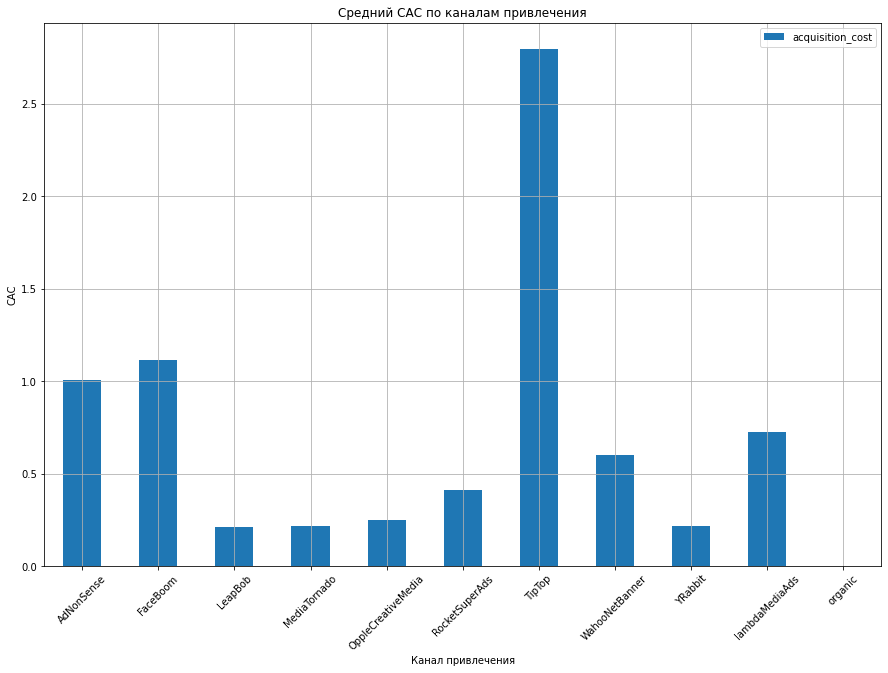

In [44]:
profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
).plot(kind='bar', grid=True, figsize=(15, 10))

plt.ylabel('CAC')
plt.xlabel('Канал привлечения')
plt.xticks(rotation=45)
plt.title('Средний САС по каналам привлечения')
plt.show()

<b>Вывод:</b> На графике видно, что средний CAC по площадкам сильно различается. Самые "дорогие" клиенты - это покупатели, приходящие с TipTop, это более чем в 2 раза больше чем показывают другие каналы привлечения. 

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Окупаемость рекламы (LTV и ROI)

In [45]:
observation_date = datetime(2019, 11, 1).date() 
horizon_days = 14 

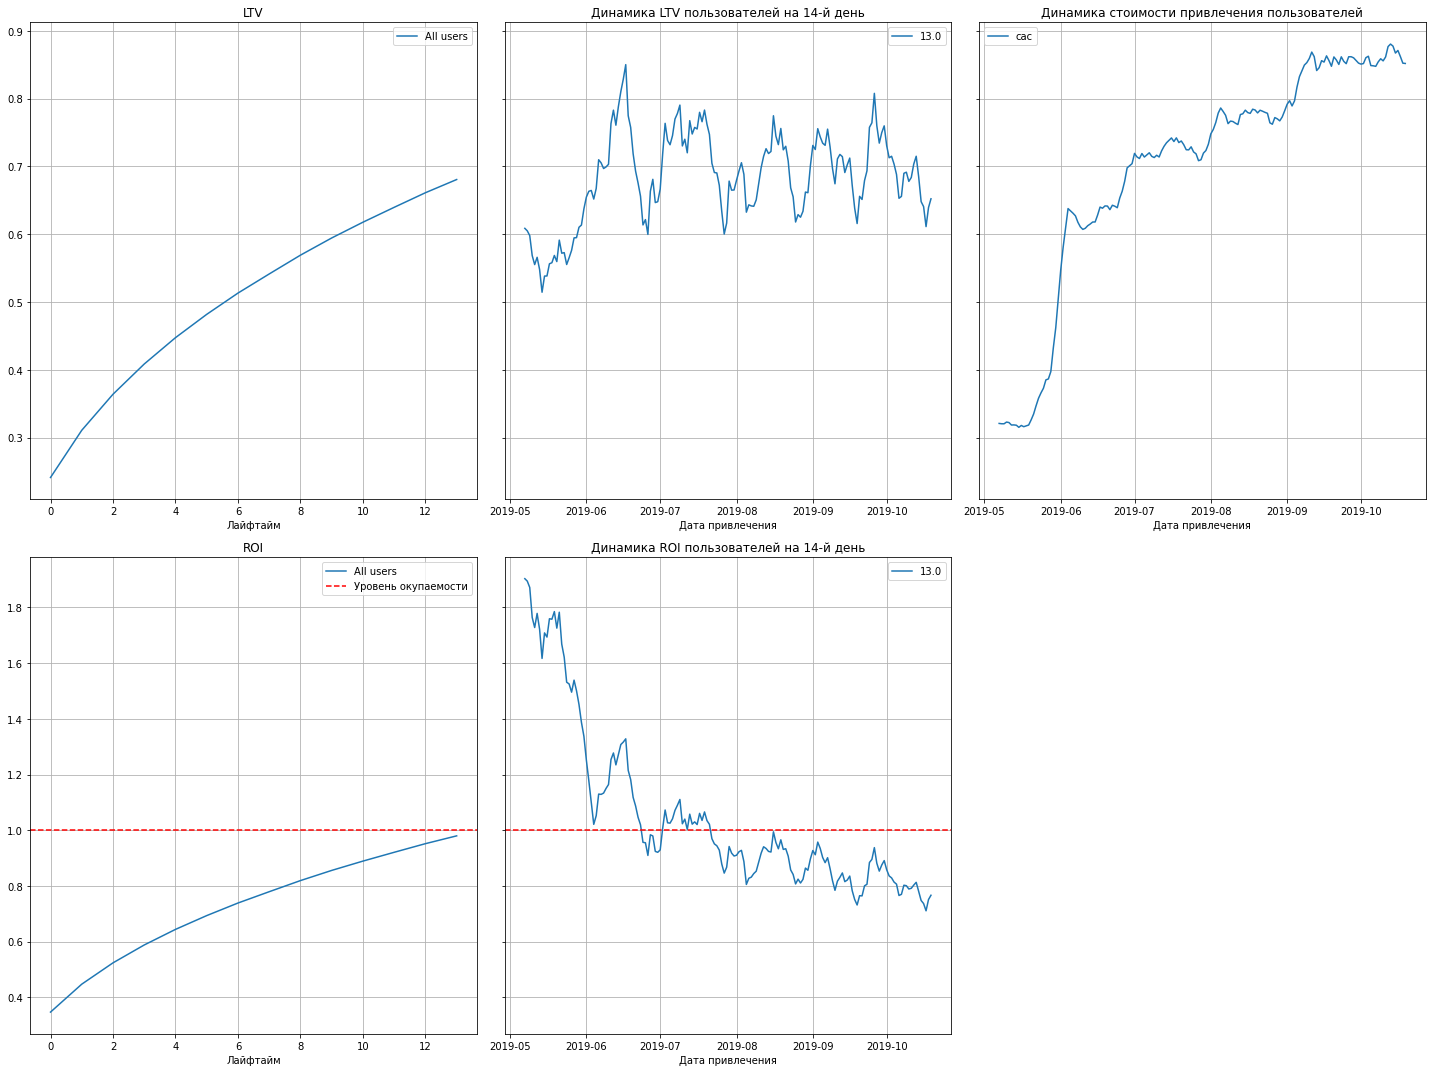

In [46]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Рассмотрим данные без канала "organic":

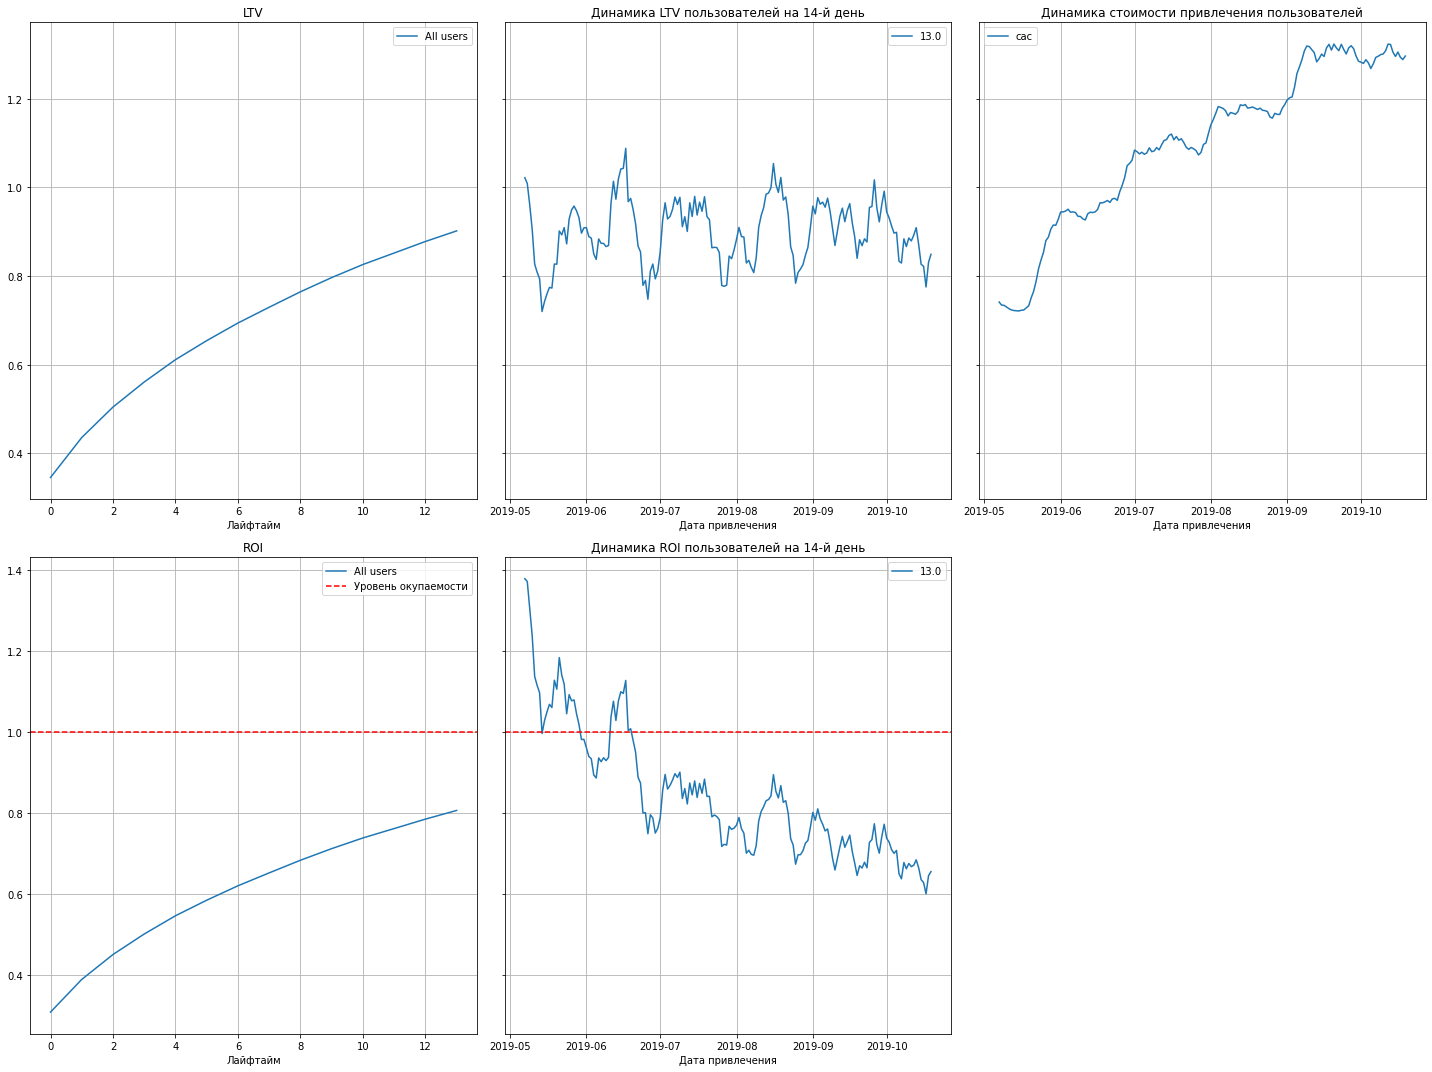

In [47]:
profiles_drop = profiles.query('channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_drop, df_orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Без органиков LTV поднялось немного выше, но при этом ROI снизился от линии окупаемости. 

<b>Вывод:</b> Реклама не достигает уровня окупаемости. Стоимость привлечения пользователей растёт, а возврат инвестиций в динамике показывает скачковое снижение и в июне опустилось ниже уровня окупаемости.  

### Конверсия пользователей и динамика её изменения

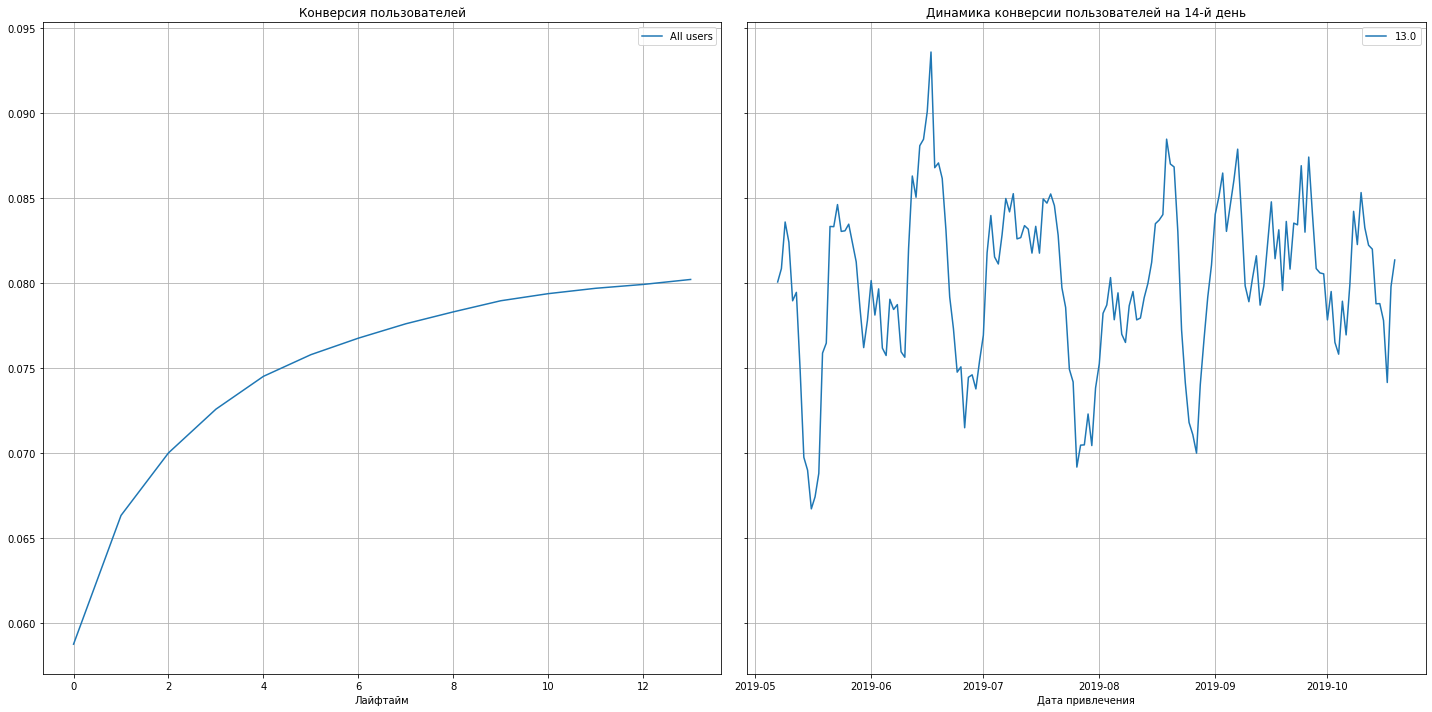

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_drop, df_orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Общая конверсия пользователей показывает хороший уровень. Соответственно проблему плохих финансовых показателей нужно искать в удержании и возврате инвестиций. Но для начала рассмотрим детальнее конверсию по платформам, регионам и каналам:

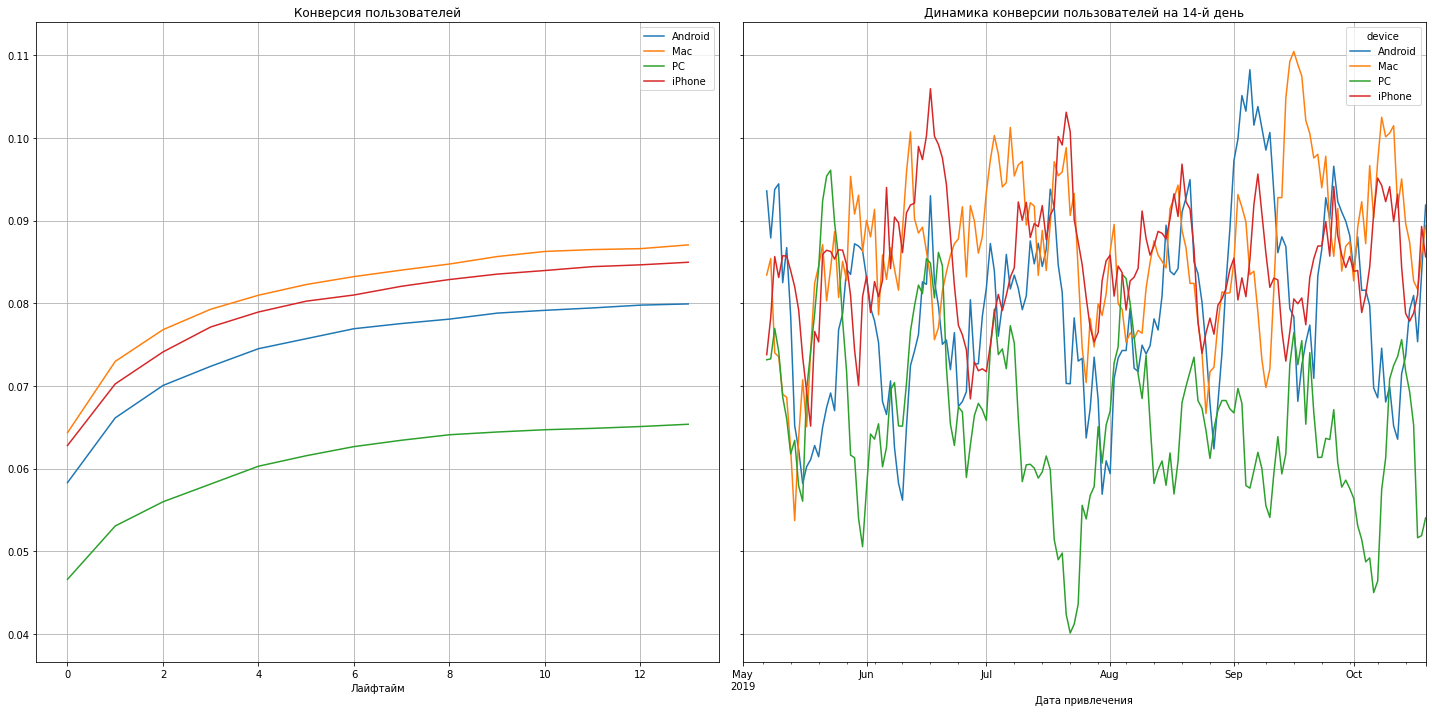

In [49]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_drop, df_orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются владельцы Mac, значительно хуже - обладатели PC. Это объяснимо тем, что на ПК значительно реже пользуются приложениями, чем на мобильных устройствах.

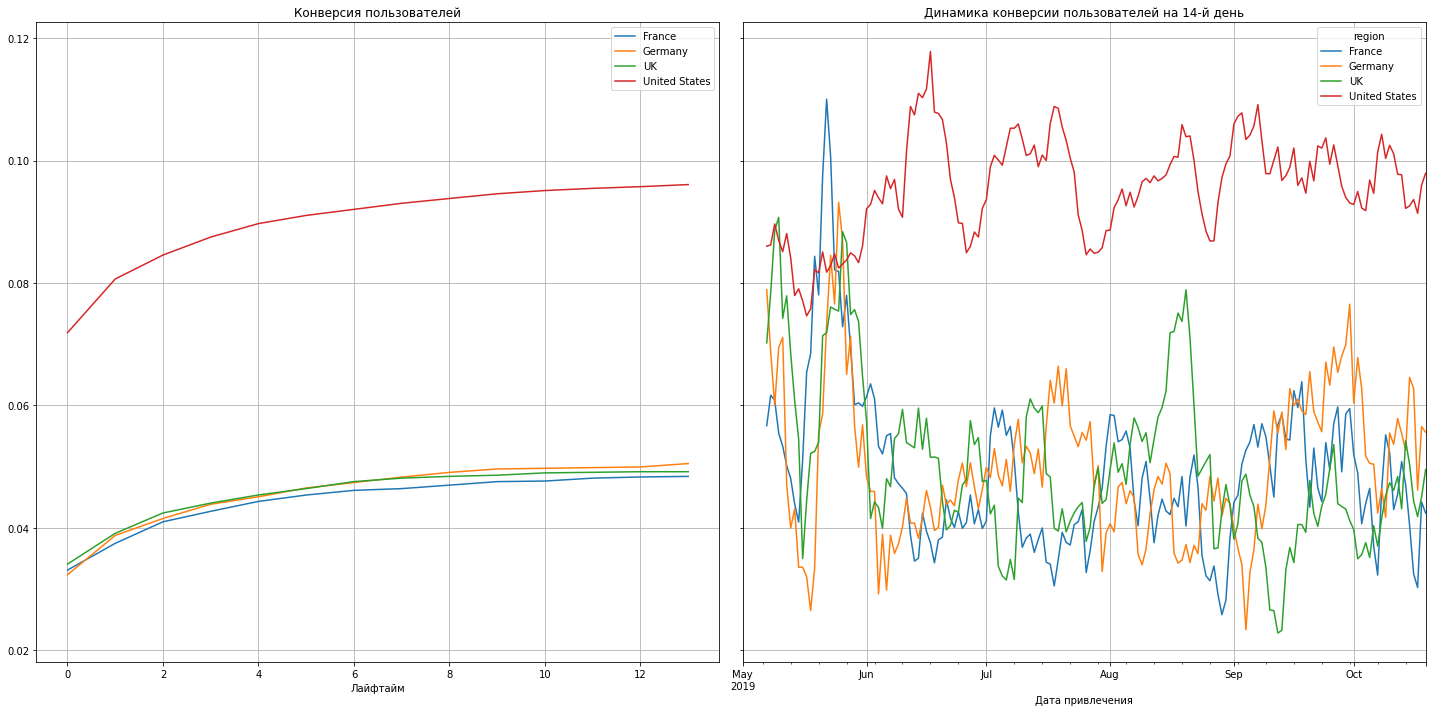

In [50]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_drop, df_orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Любопытно, что динамика конверсии `US` становится с течением времени не такой волатильной. </div>

Конверсия пользователей из Великобритании примкерно в 2 раза выше чем в других регионах. 

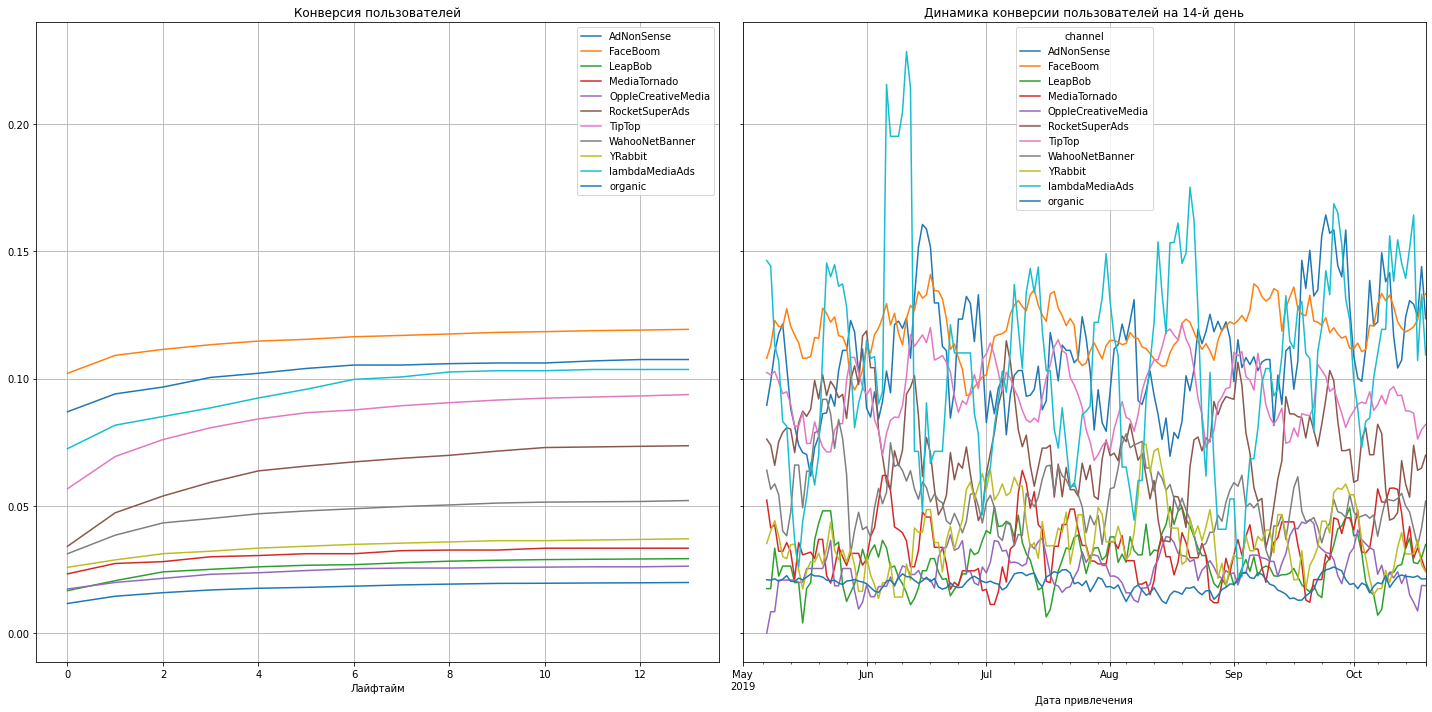

In [51]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи пришедшие с платформ: FaceBoom, AdNonSence  и lambdaMediaAds.  Хуже всего себя показывает OppleCreativeMedia, LeapBob и "органики".

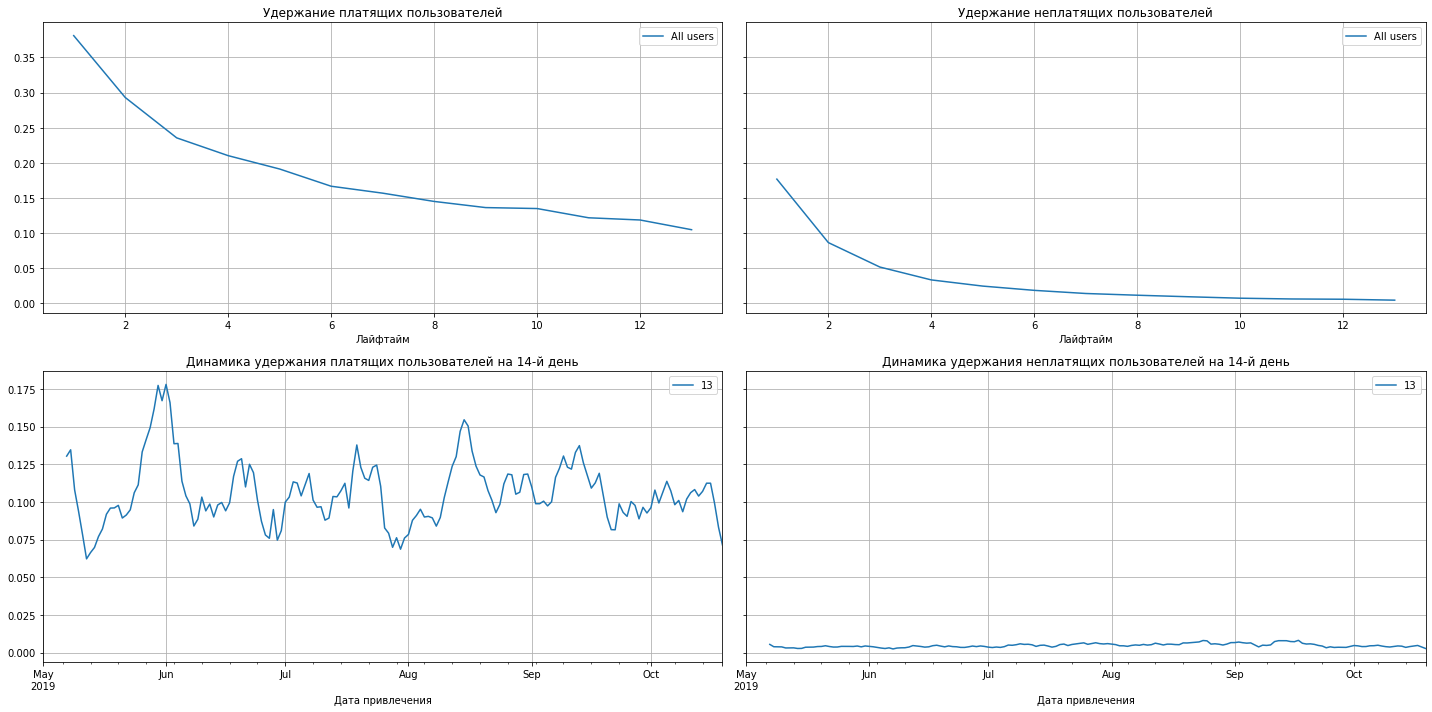

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_drop, df_visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

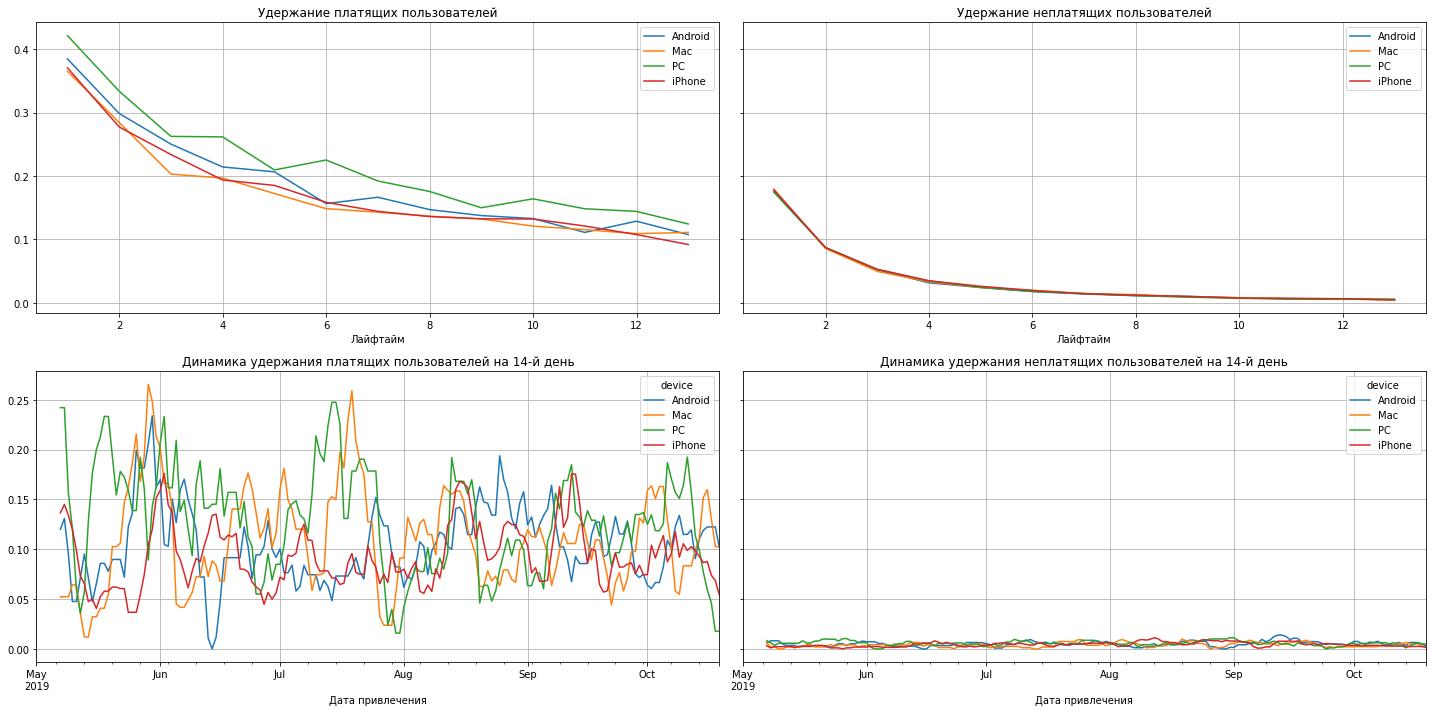

In [53]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_drop, df_visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание на платформах особо не отличается, но лучше всего себя показывает ПК. Это нецелесообразно, т.к. конверсия этой платформы самая низкая. 

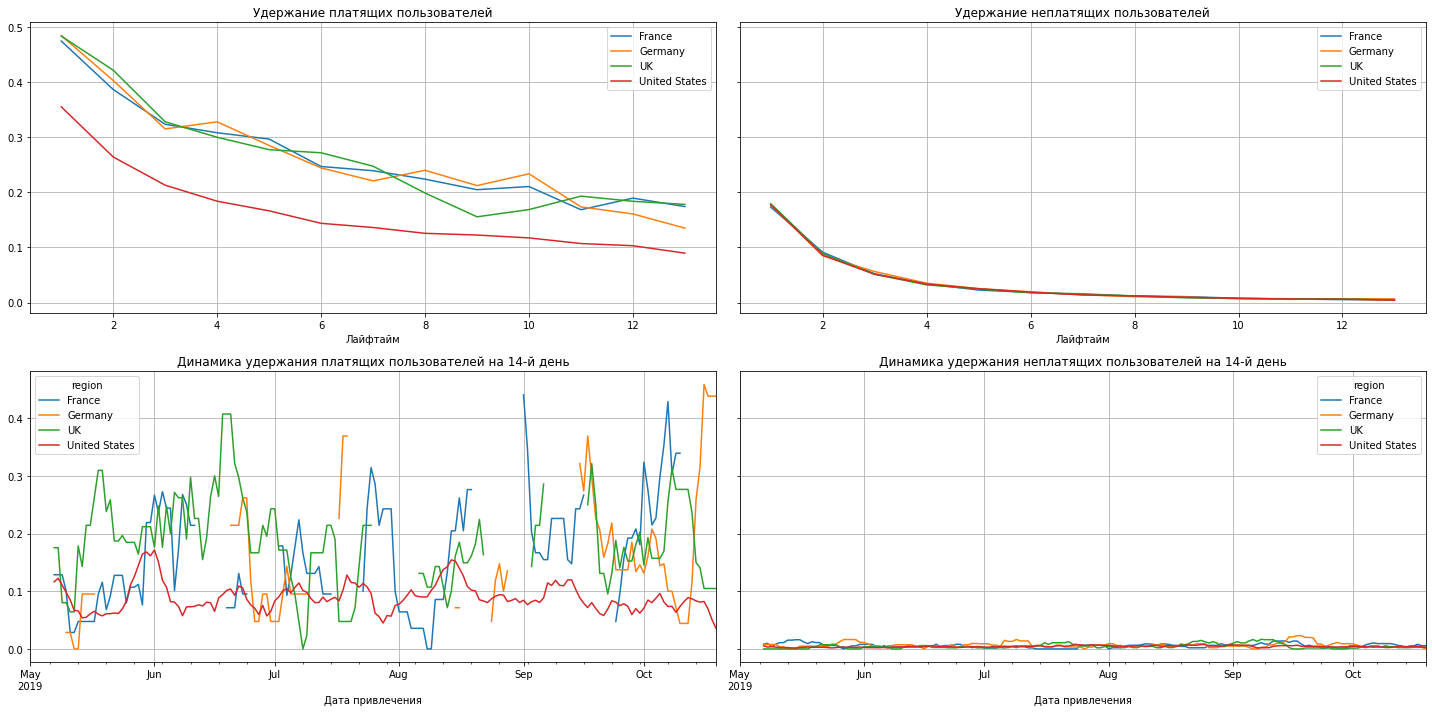

In [54]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_drop, df_visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей из Великобритании хуче чем удержание пользователей из других регионов. Это не очень хорошая ситуация, т.к. самые конвертируемые пользователи как раз из Великобритании. 

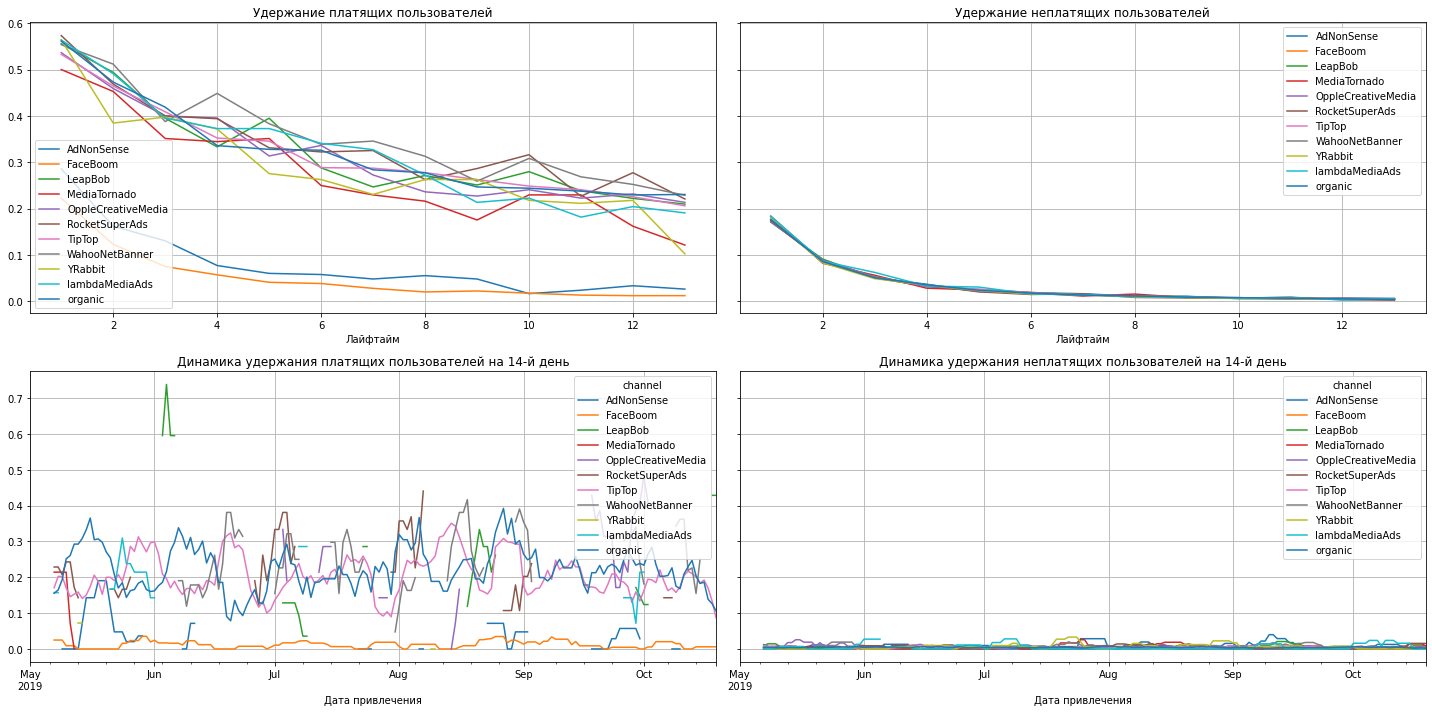

In [55]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видно, что по удержанию платящих пользователей явные аутсайдеры - FaceBoom и organic. Остальные держатся примерно на одном уровне, но на последних лайфтаймах есть падение у MediaTornado и YRabbit. 

<b>Вывод:</b> удержание как платящих, так и неплатящих пользователей резко снижается с  1 по 6 день, после удержание снижается  более плавно.  На графике динамики удержания неплатящих пользователей видно, что компния ничего не делает для удержания пользователей, которые не являются покупателями. Это не очень хорошая ситуация, т.к. больее эффективнее конвертируются пользователи в покупателей после 6 лайфтайма.\
Лучше всего конвертируются пользователи пришедшие с платформ: FaceBoom, AdNonSence  и lambdaMediaAds.  Хуже всего себя показывает OppleCreativeMedia, LeapBob и "органики".\
Конверсия пользователей из Великобритании примкерно в 2 раза выше чем в других регионах. При этом удержание в этом регионе хуже всего. \
Лучше всего конвертируются владельцы Mac, значительно хуже - обладатели PC. Это объяснимо тем, что на ПК значительно реже пользуются приложениями, чем на мобильных устройствах. Удержание на платформах особо не отличается, но лучше всего себя показывает ПК. Это нецелесообразно, т.к. конверсия этой платформы самая низкая. 

### Окупаемость рекламы с разбивкой по устройствам

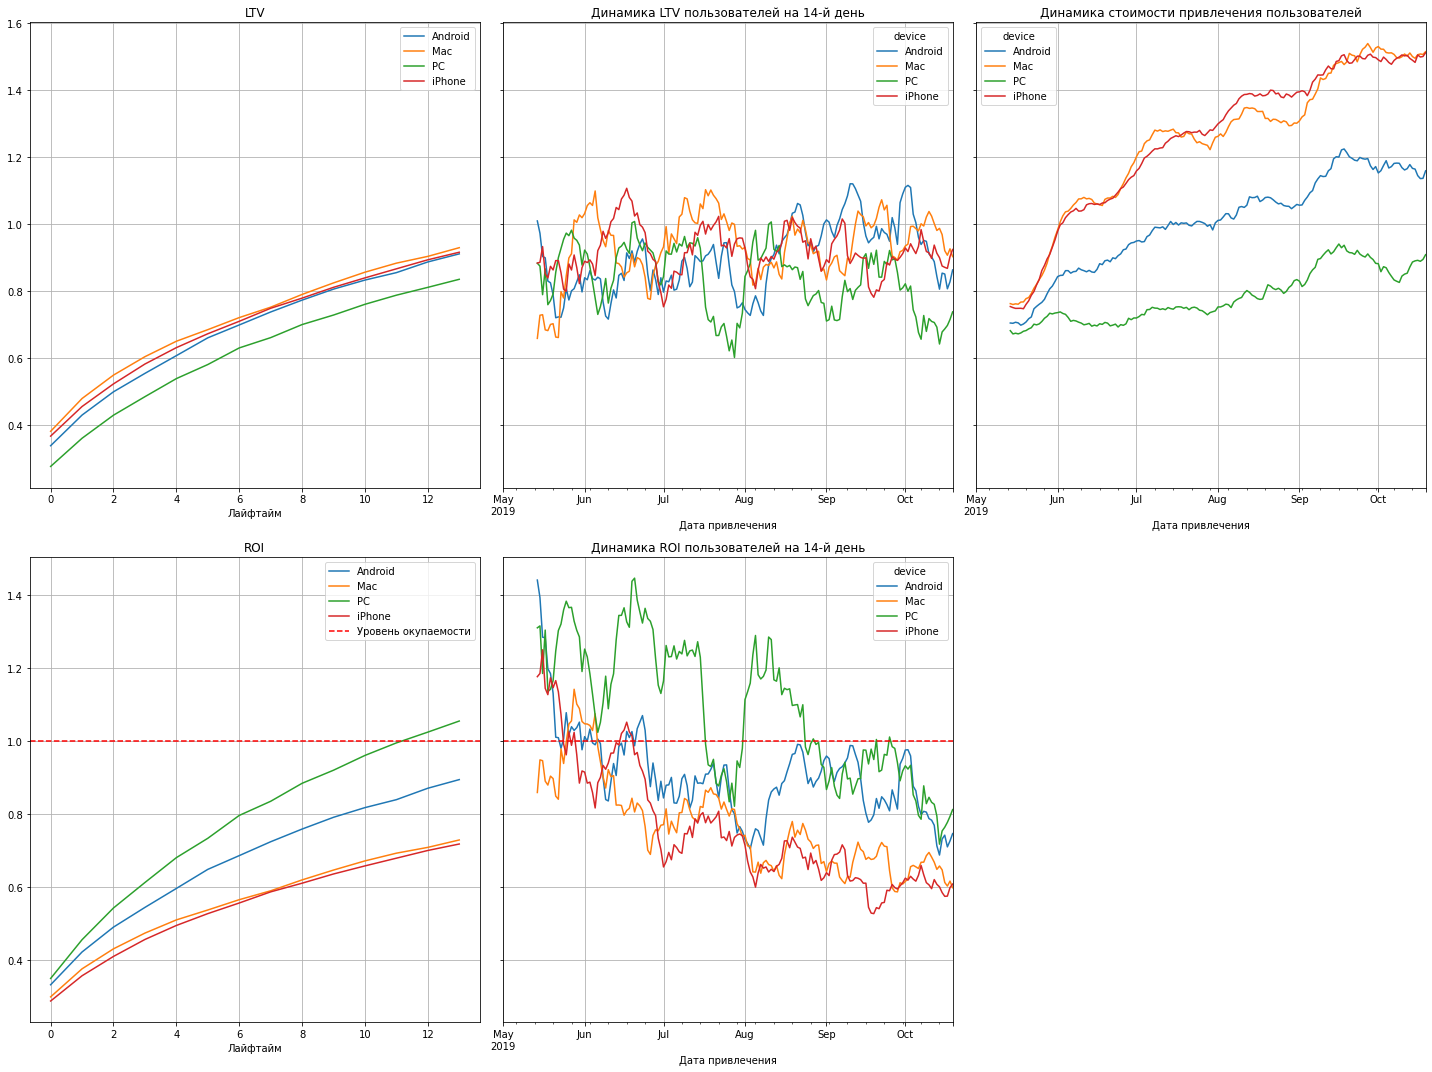

In [56]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_drop, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<b>Вывод:</b> мобильные устройства показывают примерно один уровень LTV, немного отствет от них PC. Реклама не окупается для владельцев Mac,iPhone и Android , а PC преодолел уровень окупаемости. По графикам видно, что расходы на рекламу для Mac и iPhone значительно больше, чем для других платформ, но при этом начиная с июня инвестиции не окупаются. Необходимо пересмотреть стратегию маркетинга для этих платформ, т.к. они целевая аудитория приложения.

### Окупаемость рекламы с разбивкой по странам

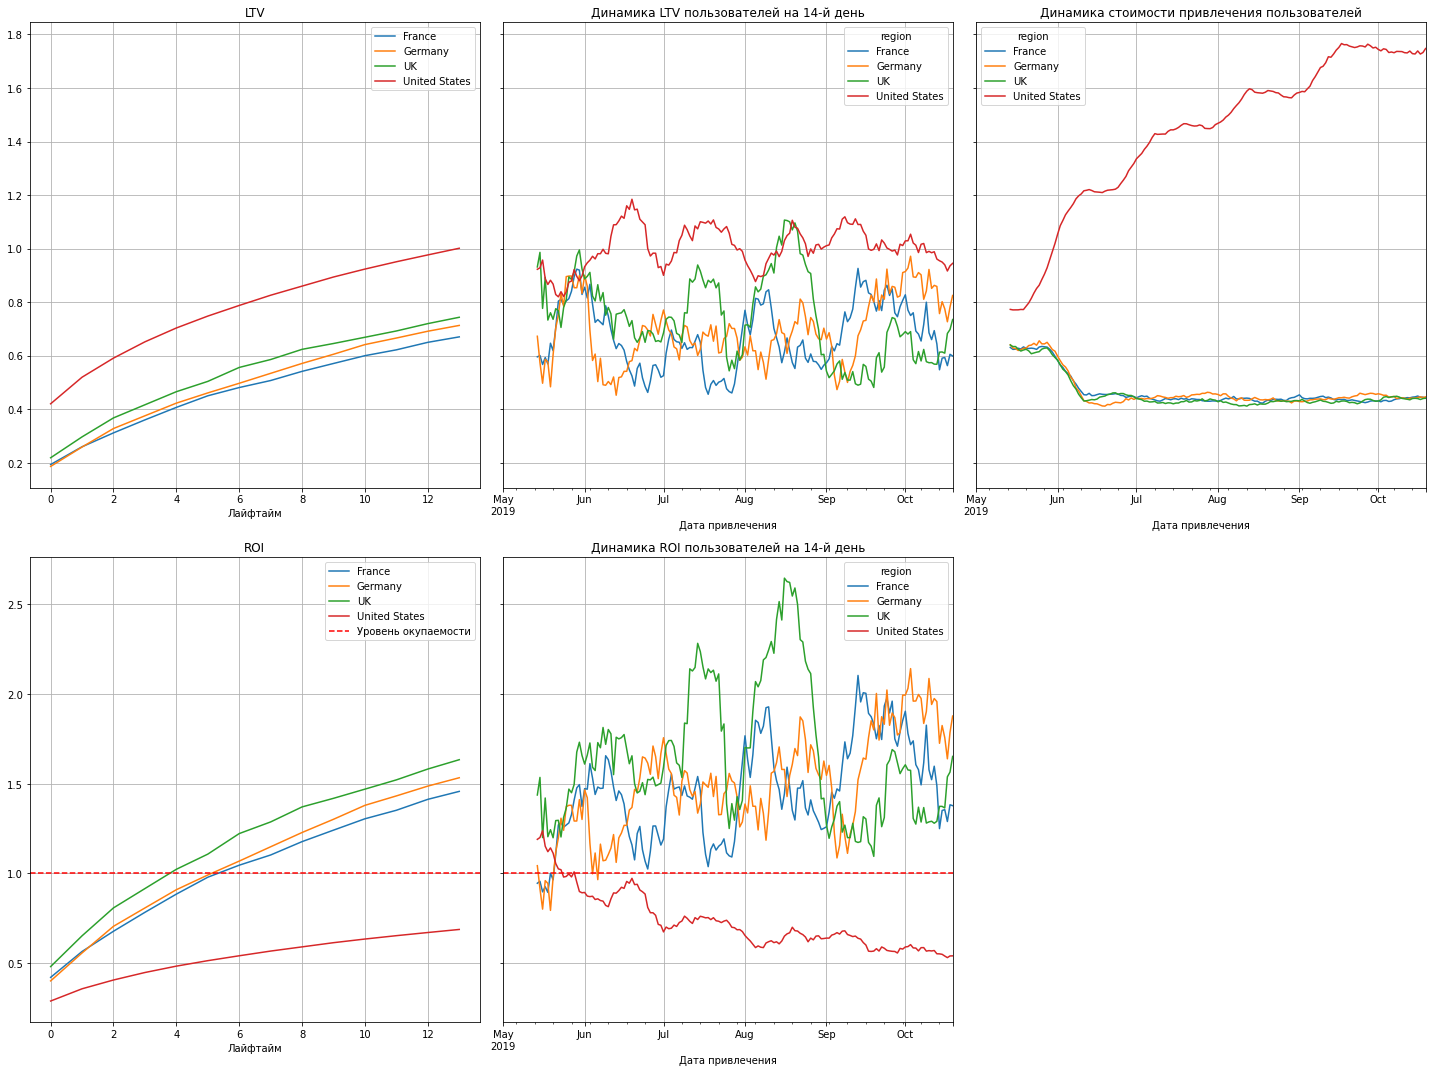

In [57]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_drop, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<b>Вывод:</b> среди регионов самый высокий LTV показывает Великобритания, менее активна Франция. При этом стоимость привлечения в США самая высокая - примерно на 80% выше чем в остальных регионах. За счет этого инвестиции только в этой стране не окупются. Необходимо срочно пересмотреть стратегию и бюджеты на рекламу в этом регионе. 

### Окупаемость рекламы с разбивкой по рекламным каналам

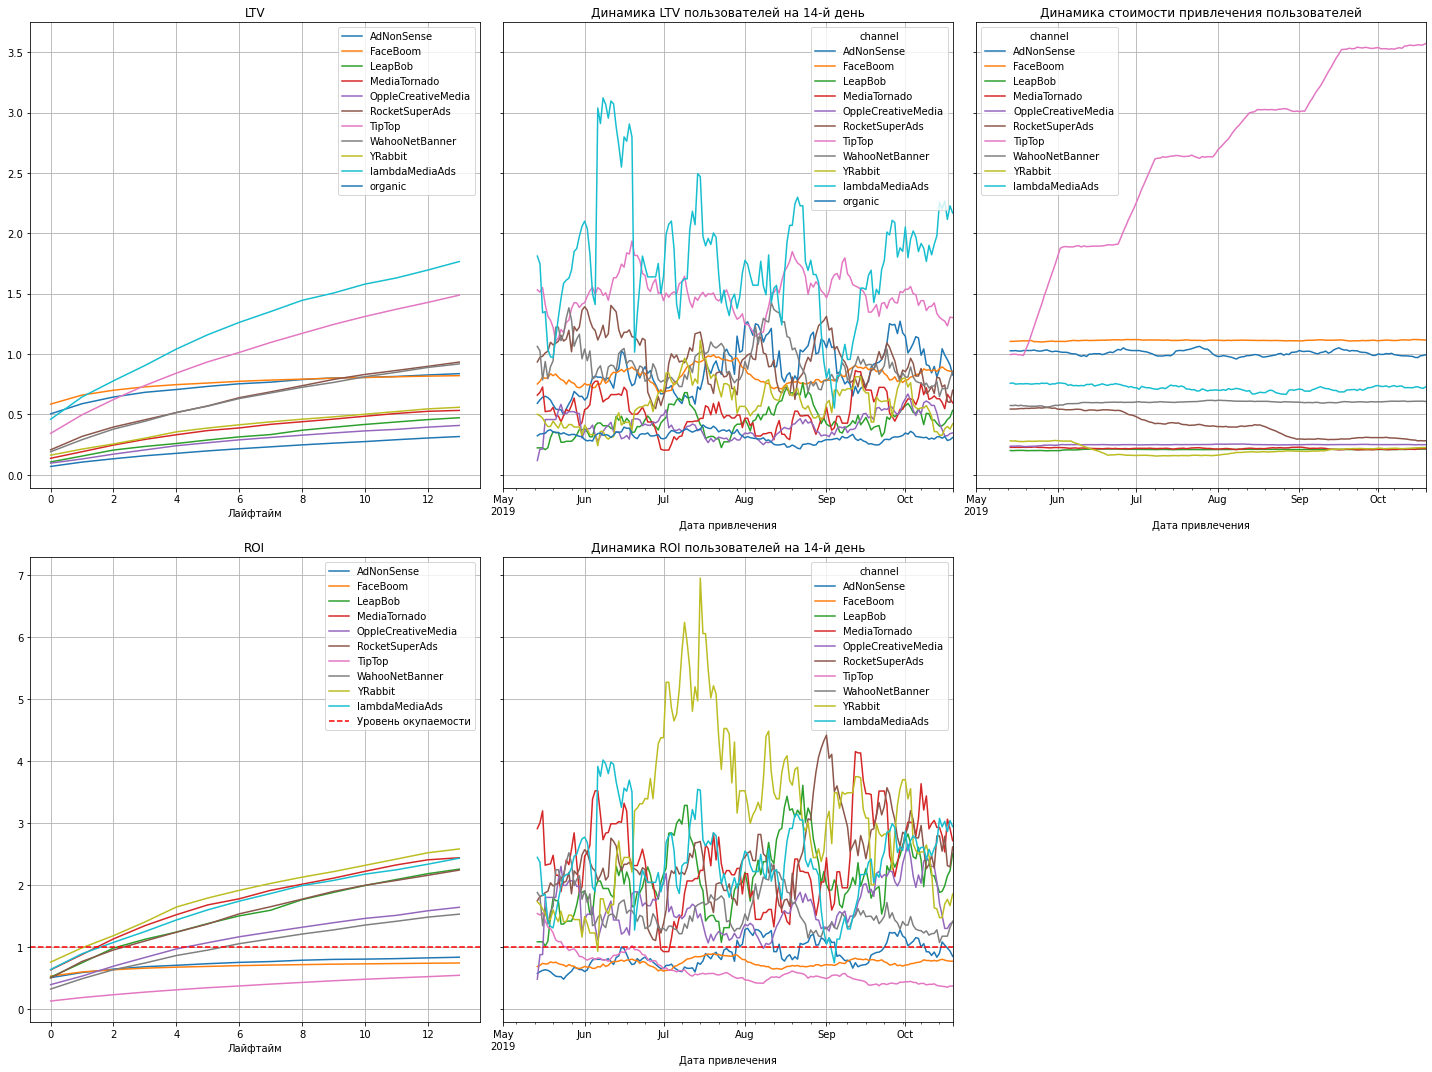

In [58]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Наиболее быстрорастущими по LTV каналами являются lambdaMediaAds и TipTop. При этом стоимость привлечения клиента на TipTop очень высока по сравнению с другими каналами - примерно в 5 раз больше чем lambdaMediaAds. lambdaMediaAds эффективнее и стоимость привлечения клиента ставбильно ниже - необходимо сфокусироваться на развитии этого канала. Хороший уровень возврата инвестиций показывают YRabbit, MediaTornado, LeapBob и RocketSuperAds. Аутсайдеры - TipTop, FaceBoom и AdNonSense, они не преодолели порог окупаемости.  

<b>Вывод:</b>реклама продукта приближается к окупаемости, но в данный момент не окупает вложенные инвестиции.
- при детальном рассмотрении выявлены негативные факторы влияющие на эффективность рекламы: чрезмерно высокие затраты на рекламу для платворм Mac, iPhone и Android, необоснованно высокие вложения в маркетинг в США и слишком большие затраты на площадке TipTop, которые не приносят пользователей так же эффективно, как другие каналы привлечения;
- проблемы окупаемости маркетинговых компаний связаны с неправильным распределением бюджетов на по источникам - средства вложены в не самые конверсируемые источники и аудитории. Еще компания не занимается удержанием пользователей - низкий уровень показывает, что пользователи уходят. А если не будет неплатящих пользователей 

## Общие выводы и рекомендации

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

<b> Причины неэффективности привлечения пользователей: </b> 
- Резко увеличили затраты на рекламу, но в связи с отсутствием аналитики площадок и целевой аудитрии, финансы были распределены нерационально. Это иллюстрируют следующие факторы: 
 - средний CAC по площадкам сильно различается. Самые "дорогие" клиенты - это покупатели, приходящие с TipTop, это более чем в 2 раза больше чем показывают другие каналы привлечения.
 - наиболее быстрорастущими по LTV каналами являются lambdaMediaAds и TipTop. При этом стоимость привлечения клиента на TipTop очень высока по сравнению с другими каналами - примерно в 5 раз больше чем lambdaMediaAds. lambdaMediaAds эффективнее и стоимость привлечения клиента ставбильно ниже - необходимо сфокусироваться на развитии этого канала. Хороший уровень возврата инвестиций показывают YRabbit, MediaTornado, LeapBob и RocketSuperAds. Аутсайдеры - TipTop, FaceBoom и AdNonSense, они не преодолели порог окупаемости. 
 - мобильные устройства показывают примерно один уровень LTV, немного отствет от них PC. Реклама не окупается для владельцев Mac и iPhone, а PC и Android преодолели уровень окупаемости. По графикам видно, что расходы на рекламу для Mac и iPhone значительно больше, чем для других платформ, но при этом начиная с июня инвестиции не окупаются. 
 - среди регионов самый высокий LTV показывает Великобритания, менее активна Франция. При этом стоимость привлечения в США самая высокая - примерно на 80% выше чем в остальных регионах. За счет этого инвестиции только в этой стране не окупются. 
- Удержание как платящих, так и неплатящих пользователей резко снижается с  1 по 6 день, после удержание снижается  более плавно.  На графике динамики удержания неплатящих пользователей видно, что компния ничего не делает для удержания пользователей, которые не являются покупателями. Это не очень хорошая ситуация, т.к. больее эффективнее конвертируются пользователи в покупателей после 6 лайфтайма. До этого конверсия меньше - от 4% до 5,5%. Для такого небольшого % превращения пользователя в покупателя необходимо увеличивать охваты пользователей.

<b>Рекомендации:</b>
- Пересмотреть распределения бюджетов на маркетинг - либо сократить вложения по каналам TipTop и FaceBoom (которые не окупаются), либо перераспределить финансы с этих каналов на более эффективные площадки - lambdaMediaAds, YRabbit, MediaTornado. 
- По региону сместить фокус на Великобританию - которая показывает самый высокий ROI, и где больше всего пользователей и доля платящих. Финансовые вложения в США не эффективны - нужно разработать другую стратегию привлечения пользователей в этом регионе и сократить затраты. 
- Стоимость привлечения пользователей Mac и iPhone не окупается, поэтому стоит рассмотреть варианты иного привлечения клиентов или снижения затрат на рекламу. 
- Нужно разработать мероприятия по удержанию неплатящих пользователей, чтобы в дальнейшем они конвертировались в покупателей. 